# Modelo ML alternativo (HistGradientBoosting) para tasas m (edad × período)
Replicamos el flujo de `b_05_ml.ipynb` usando ahora `HistGradientBoostingRegressor` (sklearn). Incluye:
- Lectura y preparación de datos (tasa_x100k -> m)
- Split temporal 1979–2018 (train) / 2019–2023 (validación)
- Entrenamiento sobre log(m)
- Métricas (RMSE, MAE, sMAPE, WAPE, RMSE_log)
- Visualizaciones (importancias, líneas, heatmaps Obs/Pred, residuales y sMAPE por celda)
- Exportaciones (matrices y formato long con errores)


In [1]:
# Imports y configuración
import os, sys, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJ_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_PATH = os.path.join(PROJ_ROOT, "data", "processed", "mortalidad")
BASE_OUT = os.path.join(PROJ_ROOT, "modelos", "outputs")
NOTEBOOK_NAME = os.path.splitext(os.path.basename(os.environ.get("NOTEBOOK_BASENAME", "b_06_ml.ipynb")))[0]
OUT_DIR = os.path.join(BASE_OUT, "output", NOTEBOOK_NAME)
os.makedirs(OUT_DIR, exist_ok=True)

print(f"Usando datos desde: {DATA_PATH}")
print(f"Guardando resultados en: {OUT_DIR}")

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 50)
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (10,5)


Usando datos desde: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/data/processed/mortalidad
Guardando resultados en: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_06_ml


In [2]:
# Estilo (viz.style)
for candidate in ("src", "../src", "../../src", "../../../src"):
    p = os.path.abspath(candidate)
    if os.path.isdir(p) and p not in sys.path:
        sys.path.append(p)
try:
    import importlib, viz.style as _vstyle
    importlib.reload(_vstyle)
except Exception:
    pass
from viz.style import apply_matplotlib_style, get_palette, get_sequential_cmap

apply_matplotlib_style(
    n_colors=7,
    base_font_size=11,
    seaborn_style="white",
    background="white",
    transparent=False,
)
print("Estilo aplicado.")


Estilo aplicado.


In [3]:
# Carga de datos y construcción matriz edad×año
file_long = os.path.join(DATA_PATH, "tasas_mortalidad_gret_per.csv")
df_long = pd.read_csv(file_long)
df_long = df_long.rename(columns={"ano": "year", "gr_et": "age"})

EPS = 1e-12
df_long_m = df_long[["year", "age", "tasa_x100k"]].copy()
df_long_m['m'] = (df_long_m['tasa_x100k'] / 1e5).clip(lower=EPS)

mat = df_long_m.pivot(index='age', columns='year', values='m').sort_index()
ages = mat.index.values
all_periods = mat.columns.values
print(mat.shape, mat.index.min(), mat.index.max(), all_periods.min(), all_periods.max())
mat.head()


(17, 45) 1 17 1979 2023


year,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000049,0.000042,0.000044,0.000039,0.000028,0.000022,0.000024,0.000018,0.000015,0.000014,0.000011,0.000010,0.000009,0.000009,0.000008,0.000006,0.000006,0.000005,0.000004,0.000006,0.000006,0.000006,0.000005,8.499482e-06,0.000007,6.534167e-06,0.000006,7.710106e-06,0.000005,8.390200e-06,0.000006,0.000003,3.653421e-06,3.153650e-06,5.815563e-06,2.921598e-06,2.398540e-06,2.666065e-06,2.392366e-06,3.153282e-06,3.668709e-06,0.000002,3.129253e-06,4.469724e-06,0.000003
2,0.000012,0.000011,0.000013,0.000010,0.000006,0.000009,0.000009,0.000007,0.000007,0.000005,0.000003,0.000004,0.000004,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000001,0.000002,0.000003,2.798329e-06,0.000002,7.009429e-07,0.000003,1.657103e-06,0.000002,1.449898e-06,0.000002,0.000002,1.249956e-06,2.527166e-07,5.106775e-07,7.732517e-07,1.559143e-06,5.224731e-07,2.617115e-07,4.921904e-07,7.389123e-07,0.000001,4.932269e-07,2.482730e-07,0.000002
3,0.000009,0.000006,0.000010,0.000009,0.000006,0.000007,0.000004,0.000005,0.000003,0.000005,0.000002,0.000004,0.000003,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000003,0.000002,0.000003,7.387396e-07,0.000003,9.613654e-07,0.000002,9.458863e-07,0.000002,9.408289e-07,0.000002,0.000002,7.141590e-07,4.802836e-07,4.853084e-07,9.816835e-07,7.445327e-07,1.002307e-06,1.515173e-06,1.401163e-06,1.396822e-06,0.000001,9.338040e-07,1.178135e-06,0.000001
4,0.000015,0.000013,0.000017,0.000014,0.000012,0.000014,0.000015,0.000008,0.000011,0.000011,0.000008,0.000006,0.000008,0.000008,0.000007,0.000007,0.000006,0.000009,0.000005,0.000006,0.000006,0.000006,0.000006,7.621104e-06,0.000005,3.371316e-06,0.000003,4.305802e-06,0.000005,4.929344e-06,0.000003,0.000003,3.584486e-06,2.853929e-06,3.324185e-06,2.852953e-06,2.863328e-06,4.075270e-06,2.891899e-06,3.997186e-06,3.474033e-06,0.000004,4.770033e-06,5.670935e-06,0.000005
5,0.000034,0.000038,0.000032,0.000031,0.000027,0.000026,0.000019,0.000019,0.000023,0.000018,0.000015,0.000014,0.000014,0.000014,0.000013,0.000016,0.000013,0.000012,0.000011,0.000012,0.000012,0.000011,0.000012,1.439396e-05,0.000011,1.262662e-05,0.000008,8.655184e-06,0.000009,1.042390e-05,0.000010,0.000005,7.747502e-06,6.875696e-06,5.778954e-06,8.438986e-06,5.401696e-06,6.803984e-06,5.055585e-06,7.018536e-06,7.070214e-06,0.000007,1.016314e-05,1.279901e-05,0.000011


In [4]:
# Dataset largo con cohort y log(m)
df_ml = (mat.reset_index().melt(id_vars='age', var_name='year', value_name='m').dropna())
df_ml['year'] = df_ml['year'].astype(int)
df_ml['age'] = df_ml['age'].astype(int)
df_ml['cohort'] = df_ml['year'] - df_ml['age']
df_ml['log_m'] = np.log(df_ml['m'].clip(lower=1e-12))
print(df_ml.head())


   age  year         m  cohort      log_m
0    1  1979  0.000049    1978  -9.923203
1    2  1979  0.000012    1977 -11.324133
2    3  1979  0.000009    1976 -11.606873
3    4  1979  0.000015    1975 -11.094065
4    5  1979  0.000034    1974 -10.301822


In [5]:
# Split temporal
train_mask = (df_ml['year'] >= 1979) & (df_ml['year'] <= 2018)
val_mask = (df_ml['year'] >= 2019) & (df_ml['year'] <= 2023)
train_df = df_ml.loc[train_mask].copy()
val_df = df_ml.loc[val_mask].copy()

features = ['age','year','cohort']
X_train = train_df[features].values
y_train = train_df['log_m'].values
X_val = val_df[features].values
y_val = val_df['log_m'].values
print(f"Rows train: {len(train_df)} | Rows val: {len(val_df)}")


Rows train: 680 | Rows val: 85


In [6]:
# Entrenamiento HistGradientBoostingRegressor (log(m))
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

hgb = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=6,
    max_iter=500,
    l2_regularization=0.0,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
)
hgb.fit(X_train, y_train)

yhat_train_log = hgb.predict(X_train)
yhat_val_log = hgb.predict(X_val)

m_train_pred = np.exp(yhat_train_log)
m_val_pred = np.exp(yhat_val_log)
m_train_obs = np.exp(y_train)
m_val_obs = np.exp(y_val)
print("Entrenamiento HistGBR completado.")


Entrenamiento HistGBR completado.


In [7]:
# Métricas
def smape(y_true, y_pred, eps=1e-12):
    return 100 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def wape(y_true, y_pred, eps=1e-12):
    return 100 * (np.sum(np.abs(y_pred - y_true)) / (np.sum(np.abs(y_true)) + eps))

RMSE_train = np.sqrt(mean_squared_error(m_train_obs, m_train_pred))
MAE_train = mean_absolute_error(m_train_obs, m_train_pred)
sMAPE_train = smape(m_train_obs, m_train_pred)
MAPE_train = np.mean(np.abs((m_train_obs - m_train_pred) / (m_train_obs + 1e-12))) * 100
WAPE_train = wape(m_train_obs, m_train_pred)
RMSE_log_train = np.sqrt(mean_squared_error(y_train, yhat_train_log))

RMSE_val = np.sqrt(mean_squared_error(m_val_obs, m_val_pred))
MAE_val = mean_absolute_error(m_val_obs, m_val_pred)
sMAPE_val = smape(m_val_obs, m_val_pred)
MAPE_val = np.mean(np.abs((m_val_obs - m_val_pred) / (m_val_obs + 1e-12))) * 100
WAPE_val = wape(m_val_obs, m_val_pred)
RMSE_log_val = np.sqrt(mean_squared_error(y_val, yhat_val_log))

print("Métricas (escala original por persona):")
print(f"- Train | RMSE: {RMSE_train:.4e} | MAE: {MAE_train:.4e} | MAPE: {MAPE_train:.2f}% | sMAPE: {sMAPE_train:.2f}% | WAPE: {WAPE_train:.2f}%")
print(f"- Val   | RMSE: {RMSE_val:.4e} | MAE: {MAE_val:.4e} | MAPE: {MAPE_val:.2f}% | sMAPE: {sMAPE_val:.2f}% | WAPE: {WAPE_val:.2f}%")
print("Métricas (escala log):")
print(f"- Train | RMSE_log: {RMSE_log_train:.4e}")
print(f"- Val   | RMSE_log: {RMSE_log_val:.4e}")


Métricas (escala original por persona):
- Train | RMSE: 1.8380e-05 | MAE: 7.8860e-06 | MAPE: 11.91% | sMAPE: 11.44% | WAPE: 8.73%
- Val   | RMSE: 1.3981e-05 | MAE: 7.4491e-06 | MAPE: 22.17% | sMAPE: 22.75% | WAPE: 17.50%
Métricas (escala log):
- Train | RMSE_log: 1.6817e-01
- Val   | RMSE_log: 3.0641e-01


In [8]:
# Reconstrucción matrices y escala 100k

def build_matrix_from_pred(df_subset, preds):
    tmp = df_subset.copy(); tmp['m_pred'] = preds
    return tmp.pivot(index='age', columns='year', values='m_pred').sort_index()

mat_train_pred = build_matrix_from_pred(train_df, m_train_pred)
mat_val_pred = build_matrix_from_pred(val_df, m_val_pred)
train_periods = np.sort(train_df['year'].unique())
val_periods = np.sort(val_df['year'].unique())

# Agregados promedio por período
df_period_train = train_df.assign(pred=m_train_pred).groupby('year')[['m','pred']].mean().reset_index().rename(columns={'year':'period','m':'obs'})
df_period_val = val_df.assign(pred=m_val_pred).groupby('year')[['m','pred']].mean().reset_index().rename(columns={'year':'period','m':'obs'})

mat_obs_100k = mat * 1e5
mat_train_pred_100k = mat_train_pred * 1e5
mat_val_pred_100k = mat_val_pred * 1e5
print('Reconstrucción completa. Listo para graficar.')


Reconstrucción completa. Listo para graficar.


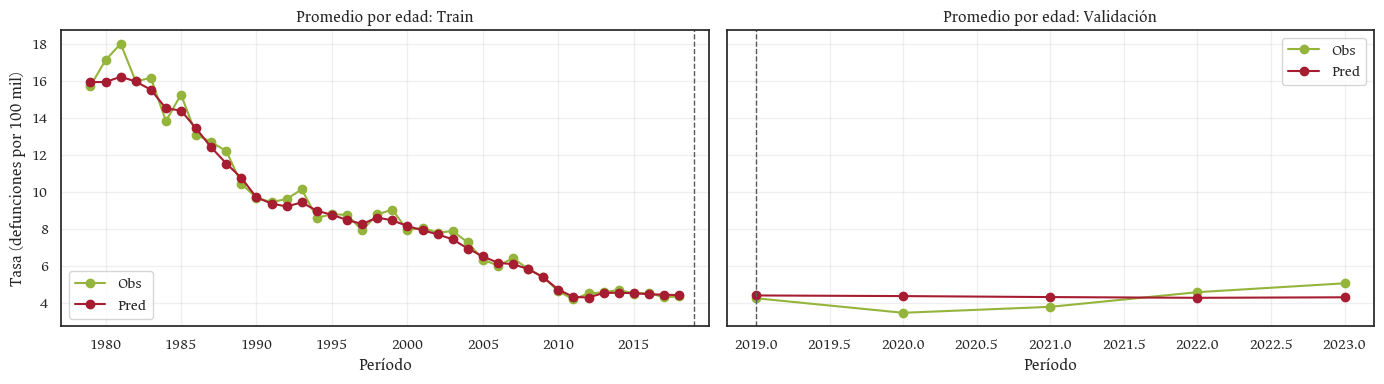

Dtype pred full: [dtype('float64')]


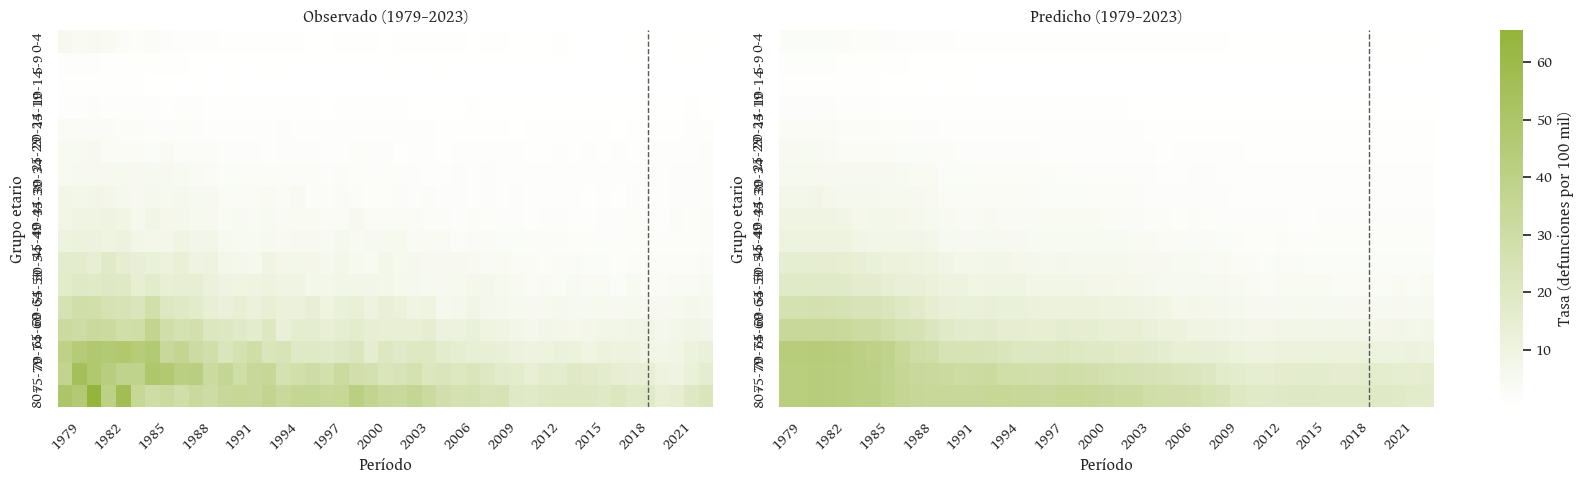

In [9]:
# Gráficos principales (importancias, líneas, heatmaps Obs/Pred) - corregido dtype
pal = get_palette(5)
color_obs, color_pred, color_vline = pal[0], pal[1], pal[4]

# Importancias (si disponible)
importances = getattr(hgb, 'feature_importances_', None)
if importances is not None:
    plt.figure(figsize=(6,4))
    plt.bar(['age','year','cohort'], importances, color=pal[0])
    plt.title('Importancia de características (HistGBR)')
    plt.ylabel('Importancia')
    plt.grid(alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,'importancias_histgbr.png'), dpi=180)
    plt.show()

# Líneas promedio por período (100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train['period'], df_period_train['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train'); ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend(); ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[1].plot(df_period_val['period'], df_period_val['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val['period'], df_period_val['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación'); ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend(); ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'lineas_obs_vs_pred_100k.png'), dpi=180); plt.show()

# Heatmaps Observado vs Predicho
# Crear matriz predicha completa asegurando dtype float
mat_pred_full_100k = pd.DataFrame(np.nan, index=ages, columns=all_periods, dtype=float)
mat_pred_full_100k.loc[:, train_periods] = mat_train_pred_100k.loc[:, train_periods].values.astype(float)
mat_pred_full_100k.loc[:, val_periods] = mat_val_pred_100k.loc[:, val_periods].values.astype(float)

# Verificación rápida
print('Dtype pred full:', mat_pred_full_100k.dtypes.unique())

vmin = float(min(mat_obs_100k.values.min(), mat_pred_full_100k.values.min()))
vmax = float(max(mat_obs_100k.values.max(), mat_pred_full_100k.values.max()))
cmap_seq = get_sequential_cmap(index=0)

ages_sorted = np.sort(ages)
if ages_sorted.min() == 0:
    age_labels = [f"{a*5}-{a*5+4}" if a < 16 else "80+" for a in ages_sorted]
else:
    age_labels = [f"{(a-1)*5}-{(a-1)*5+4}" if a < 17 else "80+" for a in ages_sorted]

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0]); ax1 = fig.add_subplot(gs[0,1], sharey=ax0); cax = fig.add_subplot(gs[0,2])

sns.heatmap(mat_obs_100k, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (1979–2023)'); ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')

sns.heatmap(mat_pred_full_100k, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho (1979–2023)'); ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

ax0.set_yticks(np.arange(len(age_labels))+0.5); ax0.set_yticklabels(age_labels)
ax1.set_yticks(np.arange(len(age_labels))+0.5); ax1.set_yticklabels(age_labels)

tick_years = np.arange(1979, 2022, 3)
period_list = list(all_periods)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)

idx_2019 = np.where(all_periods == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    ax0.axvline(xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(xline, color=color_vline, ls='--', lw=1)

cax.set_ylabel('Tasa (defunciones por 100 mil)')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'matrices_obs_pred_1979_2023_100k.png'), dpi=180); plt.show()


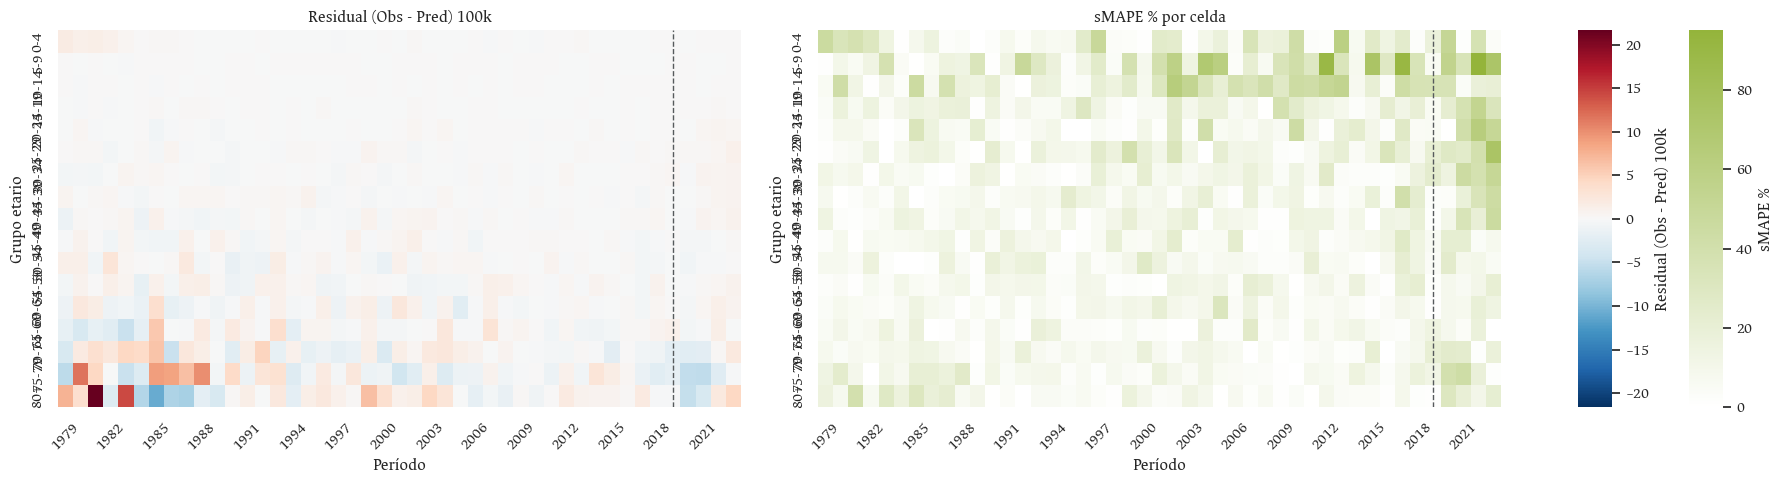

Generados heatmaps de residuales y sMAPE.


In [10]:
# Heatmaps residuales y sMAPE por celda
EPS_CELL = 1e-12
mat_pred_full_100k = mat_pred_full_100k  # del bloque anterior
resid_100k = mat_obs_100k.values - mat_pred_full_100k.values
smape_cell = (2 * np.abs(mat_pred_full_100k.values - mat_obs_100k.values) / (np.abs(mat_pred_full_100k.values) + np.abs(mat_obs_100k.values) + EPS_CELL))*100
vmax_res = np.nanmax(np.abs(resid_100k)); vmin_res = -vmax_res
vmin_sm, vmax_sm = 0, min(100, np.nanmax(smape_cell))

cmap_seq = get_sequential_cmap(index=0)
fig = plt.figure(figsize=(18,5))
gs = fig.add_gridspec(1,4, width_ratios=[1,1,0.05,0.05])
ax_r = fig.add_subplot(gs[0,0]); ax_s = fig.add_subplot(gs[0,1], sharey=ax_r); cax_r = fig.add_subplot(gs[0,2]); cax_s = fig.add_subplot(gs[0,3])

sns.heatmap(resid_100k, ax=ax_r, cmap='RdBu_r', vmin=vmin_res, vmax=vmax_res, cbar=True, cbar_ax=cax_r)
ax_r.set_title('Residual (Obs - Pred) 100k'); ax_r.set_xlabel('Período'); ax_r.set_ylabel('Grupo etario')

sns.heatmap(smape_cell, ax=ax_s, cmap=cmap_seq, vmin=vmin_sm, vmax=vmax_sm, cbar=True, cbar_ax=cax_s)
ax_s.set_title('sMAPE % por celda'); ax_s.set_xlabel('Período'); ax_s.set_ylabel('Grupo etario')

ax_r.set_yticks(np.arange(len(age_labels))+0.5); ax_r.set_yticklabels(age_labels)
ax_s.set_yticks(np.arange(len(age_labels))+0.5); ax_s.set_yticklabels(age_labels)
period_list = list(all_periods)
pos_ticks = [period_list.index(y)+0.5 for y in tick_years if y in period_list]
lab_ticks = [str(y) for y in tick_years if y in period_list]
for a in (ax_r, ax_s):
    a.set_xticks(pos_ticks); a.set_xticklabels(lab_ticks, rotation=45)
idx_2019 = np.where(all_periods == 2019)[0]
if len(idx_2019):
    xline = idx_2019[0]+0.5
    for a in (ax_r, ax_s):
        a.axvline(xline, color=color_vline, ls='--', lw=1)

cax_r.set_ylabel('Residual (Obs - Pred) 100k')
cax_s.set_ylabel('sMAPE %')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'heatmaps_residual_smape_100k.png'), dpi=180); plt.show()
print('Generados heatmaps de residuales y sMAPE.')


In [11]:
# Exportar matrices predichas (m y 100k)
mat_pred_full_m = pd.DataFrame(index=ages, columns=all_periods)
mat_pred_full_m.loc[:, train_periods] = mat_train_pred.loc[:, train_periods].values
mat_pred_full_m.loc[:, val_periods] = mat_val_pred.loc[:, val_periods].values
mat_pred_full_m.index.name = 'gr_et'
mat_pred_full_100k.index.name = 'gr_et'

mat_pred_full_m.reset_index().to_csv(os.path.join(OUT_DIR,'matriz_pred_m.csv'), index=False)
mat_pred_full_100k.reset_index().to_csv(os.path.join(OUT_DIR,'matriz_pred_tasa_x100k.csv'), index=False)
print('Exportadas matrices predichas.')


Exportadas matrices predichas.


In [12]:
# Exportar formato long con obs/pred y errores (100k)
EPS_ERR = 1e-12
train_pred_df = train_df.copy(); train_pred_df['pred_m'] = m_train_pred
val_pred_df = val_df.copy(); val_pred_df['pred_m'] = m_val_pred
for d in (train_pred_df, val_pred_df):
    d['obs_tasa_x100k'] = d['m'] * 1e5
    d['pred_tasa_x100k'] = d['pred_m'] * 1e5
    d['abs_error_100k'] = (d['pred_tasa_x100k'] - d['obs_tasa_x100k']).abs()
    d['rel_abs_error'] = d['abs_error_100k'] / (d['obs_tasa_x100k'].abs() + EPS_ERR)
train_pred_df['dataset'] = 'train'; val_pred_df['dataset'] = 'valid'
cols_out = ['dataset','year','age','cohort','obs_tasa_x100k','pred_tasa_x100k','abs_error_100k','rel_abs_error']
pred_long = pd.concat([train_pred_df[cols_out], val_pred_df[cols_out]], ignore_index=True).sort_values(['dataset','year','age']).reset_index(drop=True)
long_path = os.path.join(OUT_DIR,'predicciones_long_100k.csv')
pred_long.to_csv(long_path, index=False)
print(f'Exportado formato long a: {long_path} | Filas: {len(pred_long)}')
print(pred_long.head())


Exportado formato long a: /Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/modelos/outputs/output/b_06_ml/predicciones_long_100k.csv | Filas: 765
  dataset  year  age  cohort  obs_tasa_x100k  pred_tasa_x100k  abs_error_100k  rel_abs_error
0   train  1979    1    1978        4.902391         3.066676        1.835715       0.374453
1   train  1979    2    1977        1.207790         1.195964        0.011826       0.009791
2   train  1979    3    1976        0.910330         0.858059        0.052271       0.057420
3   train  1979    4    1975        1.520229         1.587155        0.066926       0.044024
4   train  1979    5    1974        3.357188         3.444547        0.087359       0.026022


# Optimización de Hiperparámetros y Re-evaluación
En esta sección buscamos mejorar el desempeño del modelo ajustando los hiperparámetros mediante una búsqueda aleatoria (`RandomizedSearchCV`). Utilizamos `TimeSeriesSplit` para la validación cruzada, respetando el orden temporal de los datos. Posteriormente, recalculamos las métricas y regeneramos los gráficos para el modelo optimizado.

In [26]:
# -------------------------------------------------------------------------
# 1. DICCIONARIO DE HIPERPARÁMETROS
# -------------------------------------------------------------------------
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor

print("Configurando optimización de hiperparámetros (HistGradientBoosting)...")

# Espacio de búsqueda adaptado a HistGradientBoostingRegressor
param_dist = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'max_iter': [300, 500, 800, 1200],
    'max_depth': [None, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'l2_regularization': [0.0, 0.1, 0.5, 1.0],
    'max_bins': [64, 128, 256],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.2]
}

# Validación cruzada temporal (3 splits)
tscv = TimeSeriesSplit(n_splits=3)

# Estimador base (pérdida por defecto es 'squared_error' en versiones recientes)
hgb_search = HistGradientBoostingRegressor(random_state=42)

Configurando optimización de hiperparámetros (HistGradientBoosting)...


In [27]:
# -------------------------------------------------------------------------
# 2. ENTRENAMIENTO DEL MODELO (BÚSQUEDA ALEATORIA)
# -------------------------------------------------------------------------

# Búsqueda aleatoria sobre HistGradientBoostingRegressor
random_search = RandomizedSearchCV(
    estimator=hgb_search,
    param_distributions=param_dist,
    n_iter=60,                # reducir iteraciones para tiempos razonables
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

random_search.fit(X_train, y_train)

print(f"Mejores parámetros encontrados: {random_search.best_params_}")
best_model = random_search.best_estimator_

Fitting 3 folds for each of 60 candidates, totalling 180 fits



63 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/scuartasr/Documents/Maestría/Tesis/tfm_tuberc/.venv/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Users/sc

Mejores parámetros encontrados: {'validation_fraction': 0.2, 'min_samples_leaf': 2, 'max_iter': 500, 'max_depth': 4, 'max_bins': 64, 'learning_rate': 0.05, 'l2_regularization': 0.5, 'early_stopping': True}


In [28]:
# -------------------------------------------------------------------------
# 3. CÁLCULO DE PREDICCIONES Y MÉTRICAS
# -------------------------------------------------------------------------
yhat_train_log_opt = best_model.predict(X_train)
yhat_val_log_opt = best_model.predict(X_val)

m_train_pred_opt = np.exp(yhat_train_log_opt)
m_val_pred_opt = np.exp(yhat_val_log_opt)

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error
RMSE_train_opt = np.sqrt(mean_squared_error(m_train_obs, m_train_pred_opt))
MAE_train_opt = mean_absolute_error(m_train_obs, m_train_pred_opt)
sMAPE_train_opt = 100 * np.mean(2*np.abs(m_train_pred_opt - m_train_obs) / (np.abs(m_train_pred_opt) + np.abs(m_train_obs) + 1e-12))
MAPE_train_opt = np.mean(np.abs((m_train_obs - m_train_pred_opt) / (m_train_obs + 1e-12))) * 100
WAPE_train_opt = 100 * (np.sum(np.abs(m_train_pred_opt - m_train_obs)) / (np.sum(np.abs(m_train_obs)) + 1e-12))
RMSE_log_train_opt = np.sqrt(mean_squared_error(y_train, yhat_train_log_opt))
MSE_train_opt = mean_squared_error(m_train_obs, m_train_pred_opt)

RMSE_val_opt = np.sqrt(mean_squared_error(m_val_obs, m_val_pred_opt))
MAE_val_opt = mean_absolute_error(m_val_obs, m_val_pred_opt)
sMAPE_val_opt = 100 * np.mean(2*np.abs(m_val_pred_opt - m_val_obs) / (np.abs(m_val_pred_opt) + np.abs(m_val_obs) + 1e-12))
MAPE_val_opt = np.mean(np.abs((m_val_obs - m_val_pred_opt) / (m_val_obs + 1e-12))) * 100
WAPE_val_opt = 100 * (np.sum(np.abs(m_val_pred_opt - m_val_obs)) / (np.sum(np.abs(m_val_obs)) + 1e-12))
RMSE_log_val_opt = np.sqrt(mean_squared_error(y_val, yhat_val_log_opt))
MSE_val_opt = mean_squared_error(m_val_obs, m_val_pred_opt)

print("\n--- Métricas Modelo Optimizado ---")
print(f"Train | RMSE: {RMSE_train_opt:.4e} | MSE: {MSE_train_opt:.4e} | MAE: {MAE_train_opt:.4e} | MAPE: {MAPE_train_opt:.2f}% | sMAPE: {sMAPE_train_opt:.2f}% | WAPE: {WAPE_train_opt:.2f}%")
print(f"Val   | RMSE: {RMSE_val_opt:.4e} | MSE: {MSE_val_opt:.4e} | MAE: {MAE_val_opt:.4e} | MAPE: {MAPE_val_opt:.2f}% | sMAPE: {sMAPE_val_opt:.2f}% | WAPE: {WAPE_val_opt:.2f}%")

# Preparación de datos para gráficos (reconstrucción de matrices)
def build_matrix_from_pred(df_subset, preds):
    tmp = df_subset.copy()
    tmp["m_pred"] = preds
    mat_pred = tmp.pivot(index="age", columns="year", values="m_pred").sort_index()
    return mat_pred

mat_train_pred_opt = build_matrix_from_pred(train_df, m_train_pred_opt)
mat_val_pred_opt = build_matrix_from_pred(val_df, m_val_pred_opt)

# Agregados por período
df_period_train_opt = train_df.assign(pred=m_train_pred_opt).groupby("year")[ ["m","pred"] ].mean().reset_index()
df_period_val_opt = val_df.assign(pred=m_val_pred_opt).groupby("year")[ ["m","pred"] ].mean().reset_index()
df_period_train_opt.rename(columns={"year":"period","m":"obs"}, inplace=True)
df_period_val_opt.rename(columns={"year":"period","m":"obs"}, inplace=True)

# Matrices completas (escala 100k)
mat_train_pred_opt_100k = mat_train_pred_opt * 1e5
mat_val_pred_opt_100k = mat_val_pred_opt * 1e5
mat_pred_full_opt_100k = pd.DataFrame(index=ages, columns=all_periods, dtype=float)
mat_pred_full_opt_100k.loc[:, train_periods] = mat_train_pred_opt_100k.loc[:, train_periods].values
mat_pred_full_opt_100k.loc[:, val_periods] = mat_val_pred_opt_100k.loc[:, val_periods].values


--- Métricas Modelo Optimizado ---
Train | RMSE: 1.5594e-05 | MSE: 2.4318e-10 | MAE: 6.9952e-06 | MAPE: 10.76% | sMAPE: 10.38% | WAPE: 7.74%
Val   | RMSE: 1.2794e-05 | MSE: 1.6369e-10 | MAE: 6.7286e-06 | MAPE: 21.02% | sMAPE: 20.23% | WAPE: 15.81%


In [29]:
# -------------------------------------------------------------------------
# 4. GRÁFICO: IMPORTANCIA DE CARACTERÍSTICAS
# -------------------------------------------------------------------------
import matplotlib.pyplot as plt
importances_opt = getattr(best_model, "feature_importances_", None)
if importances_opt is not None:
    plt.figure(figsize=(6,4))
    plt.bar(["Grupo etario","Período","Cohorte"], importances_opt, color="#2ca25f")
    plt.title("Importancia de características")
    plt.ylabel("Importancia para mejora de ajuste")
    plt.grid(alpha=0.3)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))
    plt.tight_layout()
    plt.show()

# Guardado del gráfico (si existe OUT_DIR)
try:
    import os
    plt.savefig(os.path.join(OUT_DIR, "importancias_gbr_optimizado.png"), dpi=200)
except Exception:
    pass

<Figure size 1000x500 with 0 Axes>

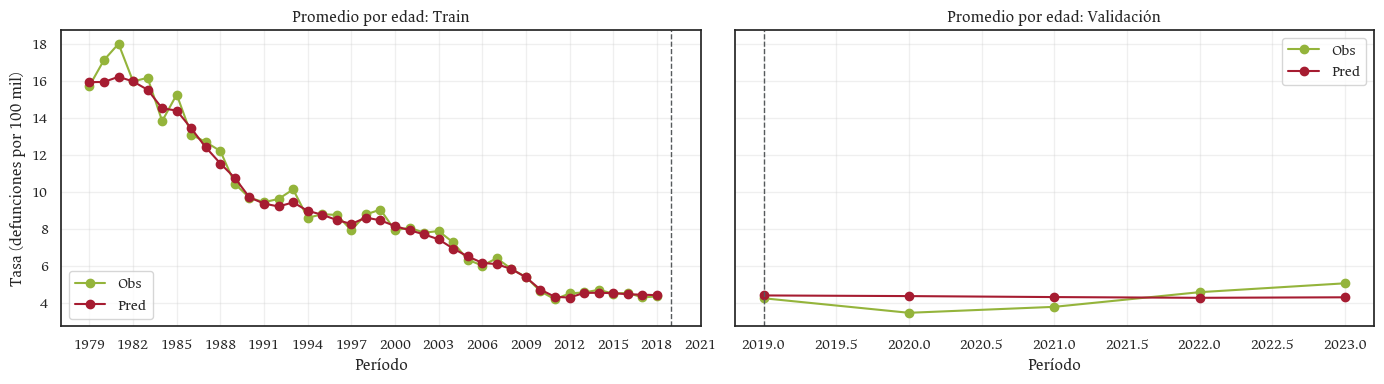

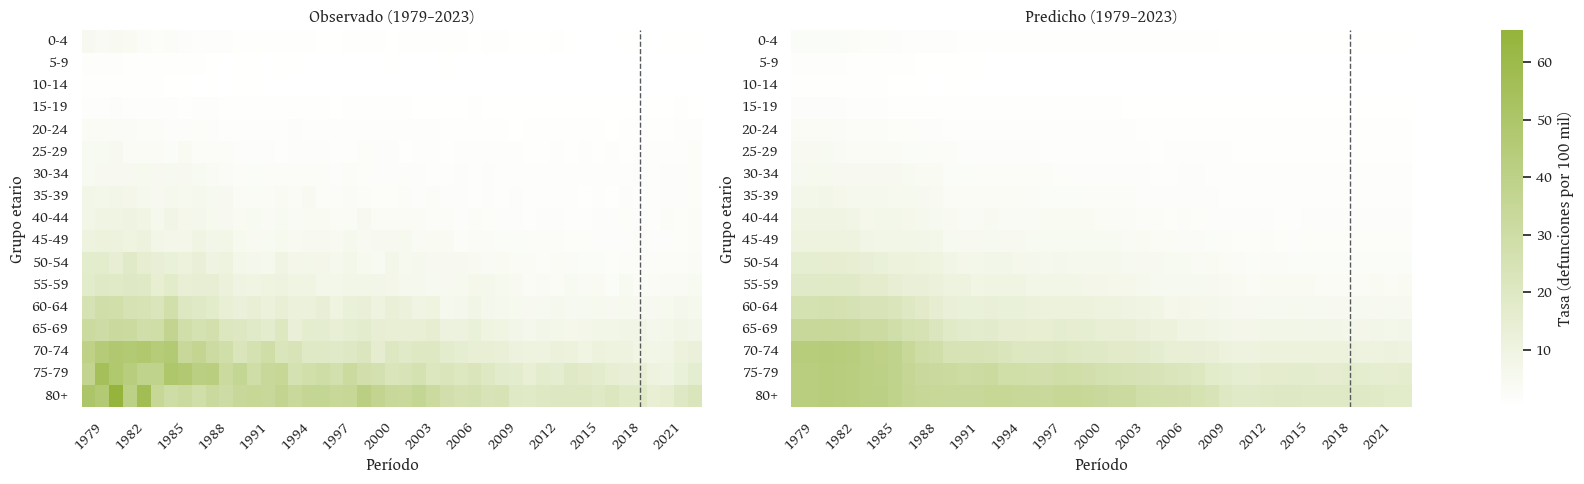

In [38]:
# Gráficos: importancias, líneas agregadas y matrices Obs vs Pred (paleta corporativa y línea 2019)
from viz.style import get_palette, get_sequential_cmap

# Colores corporativos
pal = get_palette(5)
color_obs = pal[0]      # verde corporativo (observado)
color_pred = pal[1]     # rojo vino (predicho)
color_vline = pal[4]    # gris para línea 2019

# Ticks deseados: de 3 en 3 (1979, 1982, ..., 2021)
tick_years = np.arange(1979, 2022, 3)

# Etiquetas de grupos etarios (0-4,5-9,...,75-79,80+) según si el índice es 0..16 o 1..17
ages_sorted = np.sort(ages)
if ages_sorted.min() == 0:
    age_labels = [f"{a*5}-{a*5+4}" if a < 16 else "80+" for a in ages_sorted]
else:  # caso 1..17
    age_labels = [f"{(a-1)*5}-{(a-1)*5+4}" if a < 17 else "80+" for a in ages_sorted]

importances = getattr(best_model, "feature_importances_", None)
if importances is not None:
    plt.figure(figsize=(6,4))
    plt.bar(["age","year","cohort"], importances, color=pal[0])
    plt.title("Importancia de características (GBR)")
    plt.ylabel("Importancia")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "importancias_gbr.png"), dpi=200)
    plt.show()

# Líneas: promedio por período con colores corporativos (escala por 100k)
fig, ax = plt.subplots(1,2, figsize=(14,4), sharey=True)
ax[0].plot(df_period_train['period'], df_period_train['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[0].plot(df_period_train['period'], df_period_train['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[0].set_title('Promedio por edad: Train')
ax[0].set_xlabel('Período'); ax[0].set_ylabel('Tasa (defunciones por 100 mil)'); ax[0].grid(alpha=0.3); ax[0].legend()
ax[0].axvline(2019, color=color_vline, ls='--', lw=1)
ax[0].set_xticks(tick_years)

ax[1].plot(df_period_val['period'], df_period_val['obs']*1e5, label='Obs', marker='o', color=color_obs)
ax[1].plot(df_period_val['period'], df_period_val['pred']*1e5, label='Pred', marker='o', color=color_pred)
ax[1].set_title('Promedio por edad: Validación')
ax[1].set_xlabel('Período'); ax[1].grid(alpha=0.3); ax[1].legend()
ax[1].axvline(2019, color=color_vline, ls='--', lw=1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "lineas_obs_vs_pred_100k.png"), dpi=200)
plt.show()

# Matrices: Observado vs Predicho con colormap secuencial corporativo y colorbar compartido (escala por 100k)
mat_pred_full_100k = pd.DataFrame(index=ages, columns=all_periods, dtype=float)
mat_pred_full_100k.loc[:, train_periods] = mat_train_pred_100k.loc[:, train_periods].values
mat_pred_full_100k.loc[:, val_periods] = mat_val_pred_100k.loc[:, val_periods].values

vmin = float(min(mat_obs_100k.values.min(), mat_pred_full_100k.values.min()))
vmax = float(max(mat_obs_100k.values.max(), mat_pred_full_100k.values.max()))

cmap_seq = get_sequential_cmap(index=0)  # gradiente blanco→color corporativo 0

fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,1,0.035])
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1], sharey=ax0)
cax = fig.add_subplot(gs[0,2])

# Heatmaps
sns.heatmap(mat_obs_100k.values, ax=ax0, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=False)
ax0.set_title('Observado (1979–2023)')
ax0.set_xlabel('Período'); ax0.set_ylabel('Grupo etario')

hm = sns.heatmap(mat_pred_full_100k.values, ax=ax1, cmap=cmap_seq, vmin=vmin, vmax=vmax, cbar=True, cbar_ax=cax)
ax1.set_title('Predicho (1979–2023)')
ax1.set_xlabel('Período'); ax1.set_ylabel('Grupo etario')

# Ajustar etiquetas de grupos etarios
ax0.set_yticks(np.arange(len(age_labels)) + 0.5)
ax0.set_yticklabels(age_labels, rotation=0)
ax1.set_yticks(np.arange(len(age_labels)) + 0.5)
ax1.set_yticklabels(age_labels, rotation=0)

# Posiciones de ticks para períodos
all_periods_list = list(all_periods)
pos_ticks = [all_periods_list.index(y) + 0.5 for y in tick_years if y in all_periods_list]
lab_ticks = [str(y) for y in tick_years if y in all_periods_list]
for a in (ax0, ax1):
    a.set_xticks(pos_ticks)
    a.set_xticklabels(lab_ticks, rotation=45)

# Línea punteada en inicio de validación (2019)
idx_2019 = np.where(all_periods == 2019)[0]
if len(idx_2019) > 0:
    xline = idx_2019[0] + 0.5
    ax0.axvline(x=xline, color=color_vline, ls='--', lw=1)
    ax1.axvline(x=xline, color=color_vline, ls='--', lw=1)

# Etiqueta del colorbar (tasa por 100k)
cax.set_ylabel('Tasa (defunciones por 100 mil)')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "matrices_obs_pred_1979_2023_100k.png"), dpi=200)
plt.show()


# Interpretabilidad del Modelo (SHAP)
Utilizamos SHAP (SHapley Additive exPlanations) para entender cómo cada característica contribuye a las predicciones del modelo en el conjunto de validación. Analizamos la importancia global y el impacto direccional de cada variable.

In [32]:
# Instalación y carga de SHAP (si no está disponible)
import importlib
try:
    import shap
except ImportError:
    import sys, subprocess
    print("Instalando paquete 'shap'...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
    import shap

import numpy as np
import matplotlib.pyplot as plt
import os

print(f"Versión de SHAP: {shap.__version__}")

Versión de SHAP: 0.41.0


In [33]:
# Preparar datos y explainer para HistGradientBoostingRegressor
# Usamos el modelo optimizado si existe; si no, usamos el modelo base hgb
model_for_shap = best_model if 'best_model' in globals() and best_model is not None else hgb

# SHAP para modelos tipo árbol: intentamos TreeExplainer, si falla usamos KernelExplainer
try:
    explainer = shap.TreeExplainer(model_for_shap)
    is_tree = True
except Exception as e:
    print(f"Fallo TreeExplainer ({e}); usando KernelExplainer (más lento)")
    # Baseline con mu de y_train
    background = shap.sample(X_train, 200) if X_train.shape[0] > 200 else X_train
    explainer = shap.KernelExplainer(lambda X: model_for_shap.predict(X), background)
    is_tree = False

# Calculamos SHAP en el conjunto de validación (X_val)
# Para TreeExplainer es rápido; para KernelExplainer limitamos tamaño si es grande
X_val_for_shap = X_val
if not is_tree and X_val.shape[0] > 2000:
    idx = np.random.default_rng(42).choice(X_val.shape[0], size=2000, replace=False)
    X_val_for_shap = X_val[idx]
    print(f"Usando subconjunto de validación para SHAP: {X_val_for_shap.shape}")

# Compatibilidad NumPy: alias np.bool requerido por versiones de SHAP
if not hasattr(np, 'bool'):
    np.bool = np.bool_

shap_values = explainer.shap_values(X_val_for_shap)
shap_values = np.array(shap_values)
print("SHAP calculado.")

# Nombres de características
feature_names = ["age", "year", "cohort"]

SHAP calculado.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


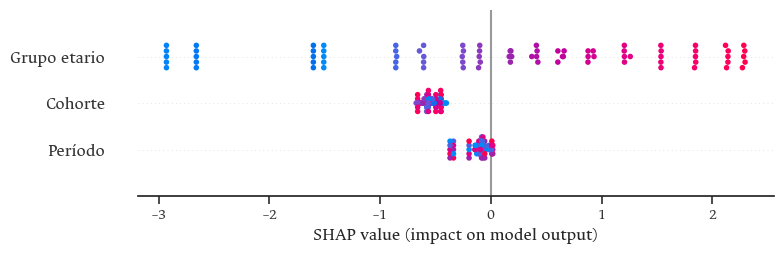

In [34]:
# Gráficas SHAP: resumen y barras de importancia global
import matplotlib.pyplot as plt
import shap

# Estilo básico
plt.figure(figsize=(8,5))
shap.summary_plot(
    shap_values, 
    X_val_for_shap, 
    feature_names=['Grupo etario', 'Período', 'Cohorte'], 
    show=False, 
    color_bar=False, )
plt.tight_layout()
try:
    plt.savefig(os.path.join(OUT_DIR, "shap_summary_plot.png"), dpi=200)
except Exception:
    pass
plt.show()

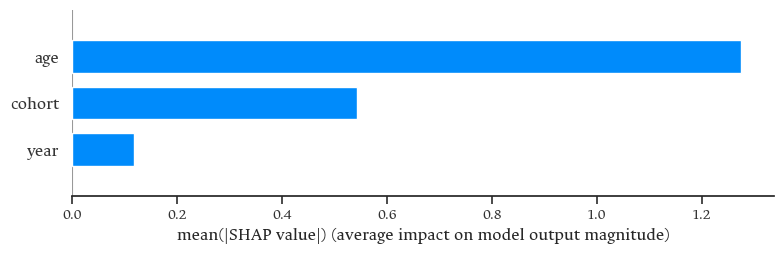

In [35]:
plt.figure(figsize=(8,5))
shap.summary_plot(shap_values, X_val_for_shap, feature_names=feature_names, plot_type='bar', show=False)
plt.tight_layout()
try:
    plt.savefig(os.path.join(OUT_DIR, "shap_importance_bar.png"), dpi=200)
except Exception:
    pass
plt.show()

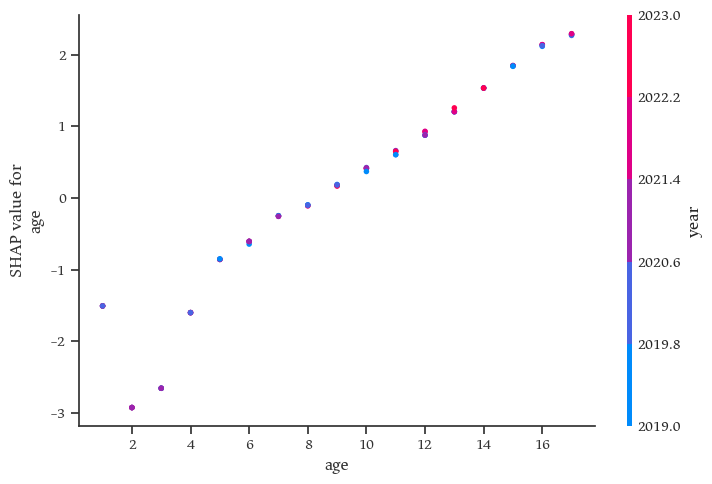

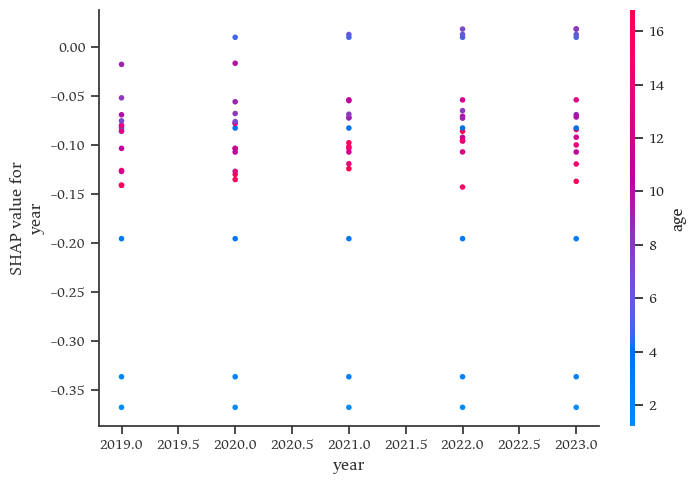

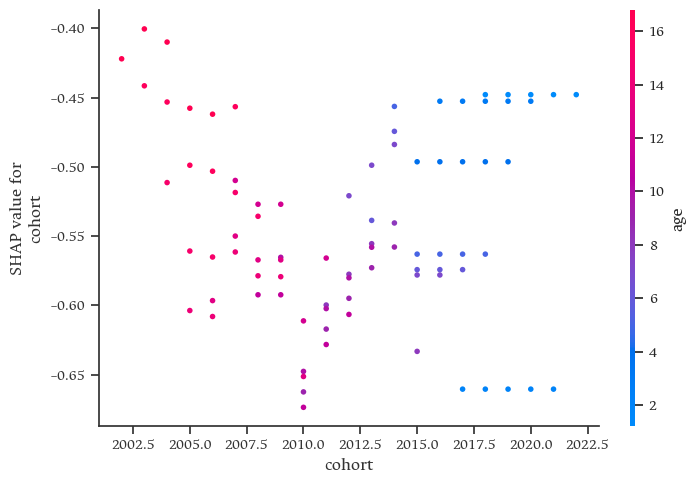

Guardadas gráficas SHAP: summary, bar e independencia por feature.


In [36]:
# Gráficas SHAP de dependencia (uno por característica)
# Shim de compatibilidad para NumPy alias
import numpy as np
if not hasattr(np, 'float'):
    np.float = np.float64

for i, fname in enumerate(feature_names):
    shap.dependence_plot(i, shap_values, X_val_for_shap, feature_names=feature_names, show=False)
    plt.tight_layout()
    try:
        plt.savefig(os.path.join(OUT_DIR, f"shap_dependence_{fname}.png"), dpi=200)
    except Exception:
        pass
    plt.show()

print("Guardadas gráficas SHAP: summary, bar e independencia por feature.")